In [1]:
from individual_files_module import *
import main_module

In [2]:
file_path = 'Data/LaFleur_supp.csv'
df = main_module.load_and_preprocess_data(file_path)

In [3]:
split_data, file_names = main_module.split_data_by_file(df)

In [4]:
# all_results = repeat_evalute_each_file(file_names, split_data, 10)
# save_repeat_evalute_each_file(all_results)
# save_repeat_evalute_each_file_statistics(all_results, split_data, file_names)

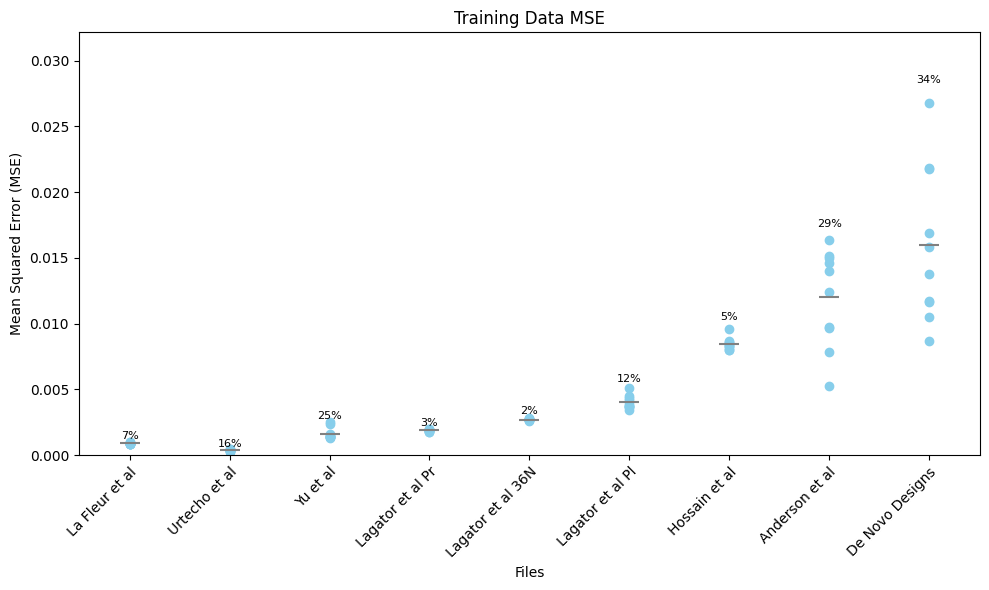

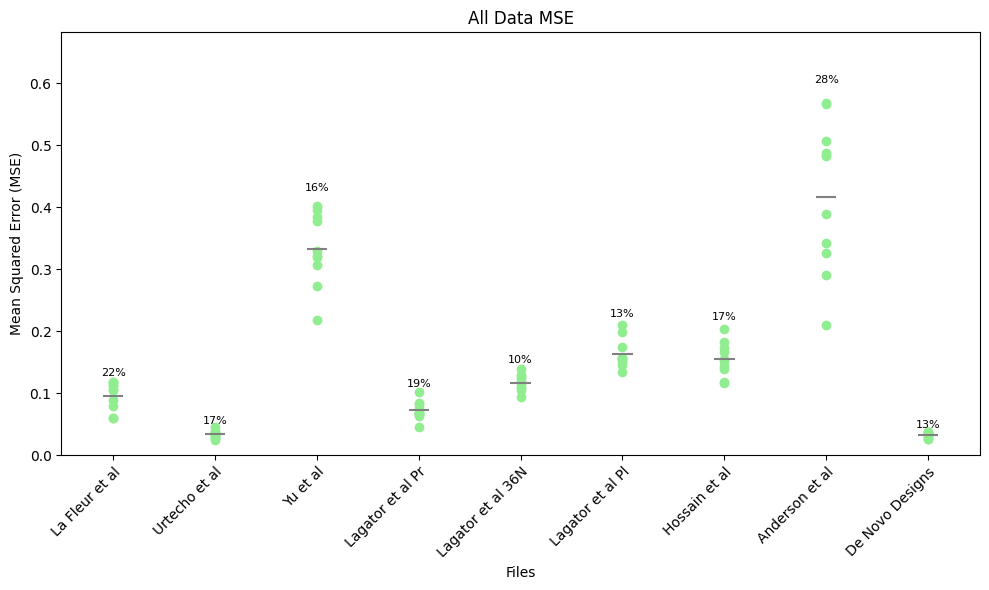

c:\Users\rsore\Documents\GitHub\e.-coli-promoter-prediction\individual_files_module.py:169: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


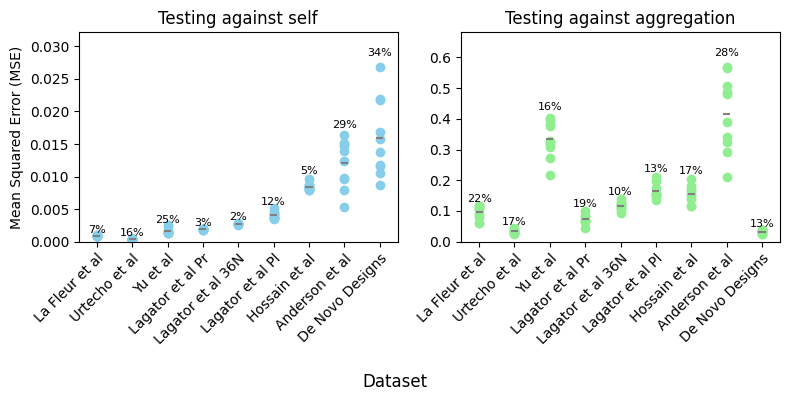

In [5]:
file_order = ['La Fleur et al', 'Urtecho et al', 'Yu et al', 'Lagator et al Pr', 'Lagator et al 36N', 'Lagator et al Pl', 'Hossain et al', 'Anderson et al', 'De Novo Designs']

all_results = load_repeat_evalute_each_file()
all_data_order, training_data_order, training_data_average_MSE, all_data_average_MSE, training_data_CV, all_data_CV = plot_repeat_evalute_each_file(file_names, all_results, file_order)

### Notes

Here, we explore what can affect the model's MSE when evaluated on it's own data and on the rest of the data. We initially assumed a large dataset would produce a model that is good at predicting the rest of the data, since Anderson et al. has 18 promoters. However, De Novo Designs only has 35 and has the lowest MSE when evaluated on the rest of the data. It also has a relatively high MSE when evaluated on its own data. Here, we compare each dataset's:
- Size
- Sequence length
- Observed log(TX/Txref) distribution
- Sequence entropy (and variance) within a file
- Sequence variance between files

To store the data, we use a pandas DataFrame

---

In [6]:
import pandas as pd

metrics_df = pd.DataFrame(file_order, columns=['File Name'])
metrics_df['Training Data CV'] = add_to_df(metrics_df, training_data_CV)
metrics_df['All Data CV'] = add_to_df(metrics_df, all_data_CV)
metrics_df['Training Data MSE Averages'] = add_to_df(metrics_df, training_data_average_MSE)
metrics_df['All Data MSE Averages'] = add_to_df(metrics_df, all_data_average_MSE)
metrics_df.head()

,File Name,Training Data CV,All Data CV,Training Data MSE Averages,All Data MSE Averages
0,La Fleur et al,0.072744,0.227085,0.000894,0.095725
1,Urtecho et al,0.164779,0.172279,0.000367,0.033381
2,Yu et al,0.258020,0.167959,0.001616,0.332792
3,Lagator et al Pr,0.039902,0.196077,0.001881,0.072140
4,Lagator et al 36N,0.026652,0.108187,0.002698,0.117030


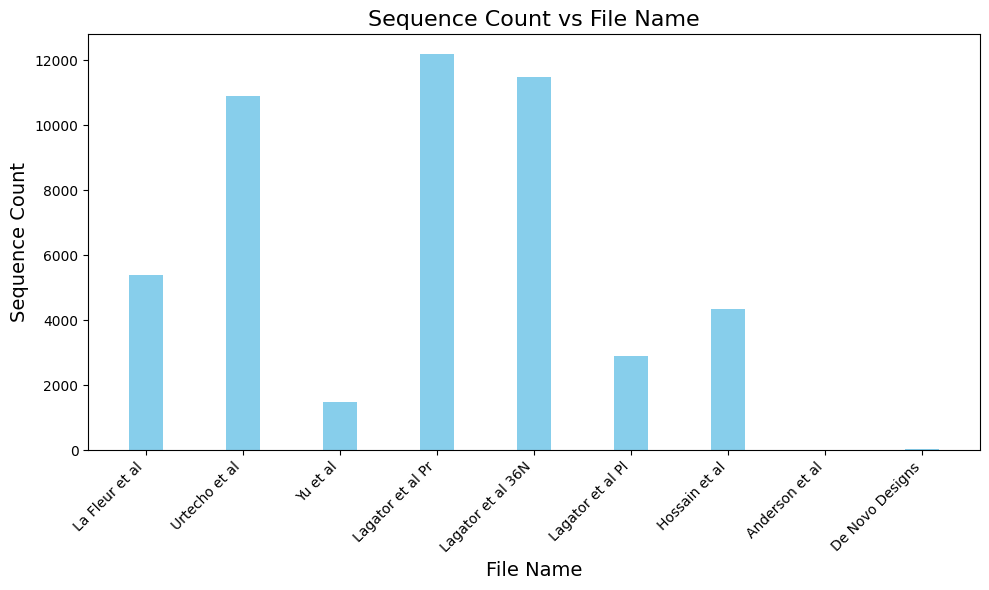

In [7]:
file_sequence_counts = get_file_sequence_counts(df)
metrics_df['Sequence Count'] = add_to_df(metrics_df, file_sequence_counts)

plot_barchart(metrics_df, 'Sequence Count')

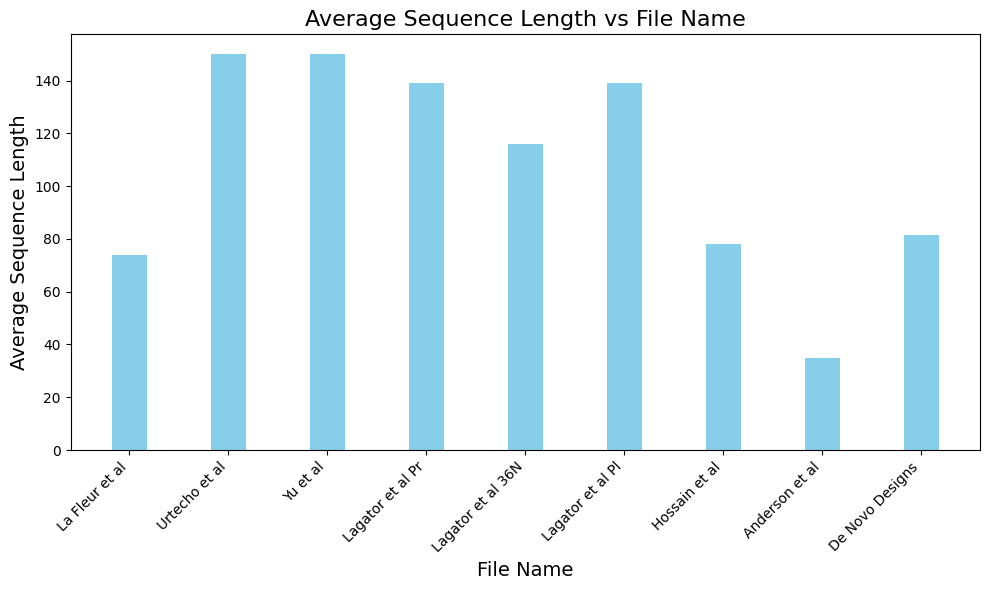

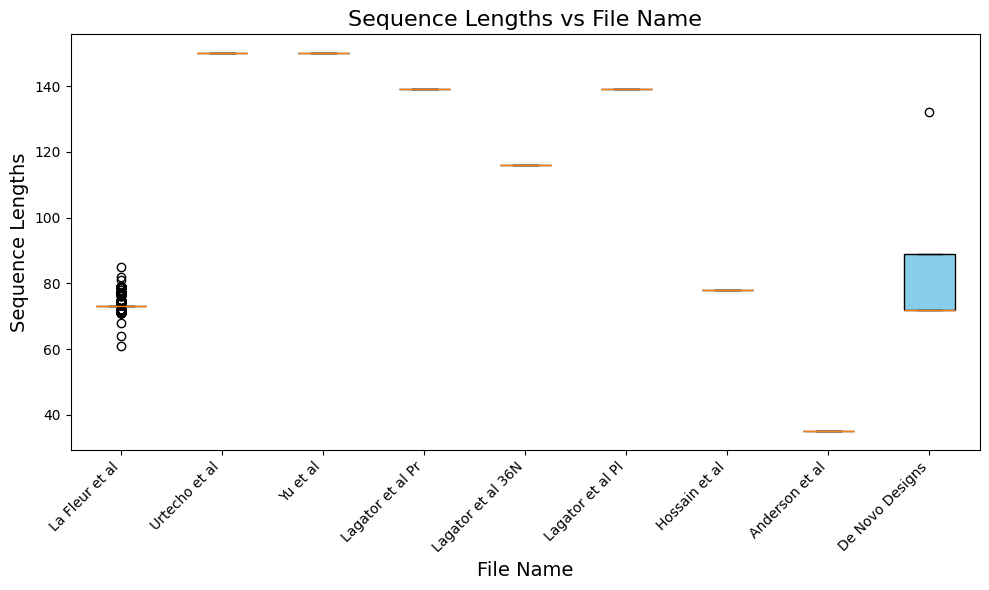

In [8]:
sequence_lengths = get_promoter_sequence_lengths(df)
average_sequence_lengths = {file : sum(lengths) / len(lengths) for file, lengths in sequence_lengths.items()}

metrics_df['Average Sequence Length'] = add_to_df(metrics_df, average_sequence_lengths)
metrics_df['Sequence Lengths'] = add_to_df(metrics_df, sequence_lengths)

plot_barchart(metrics_df, 'Average Sequence Length')
plot_boxplot(metrics_df, 'Sequence Lengths')

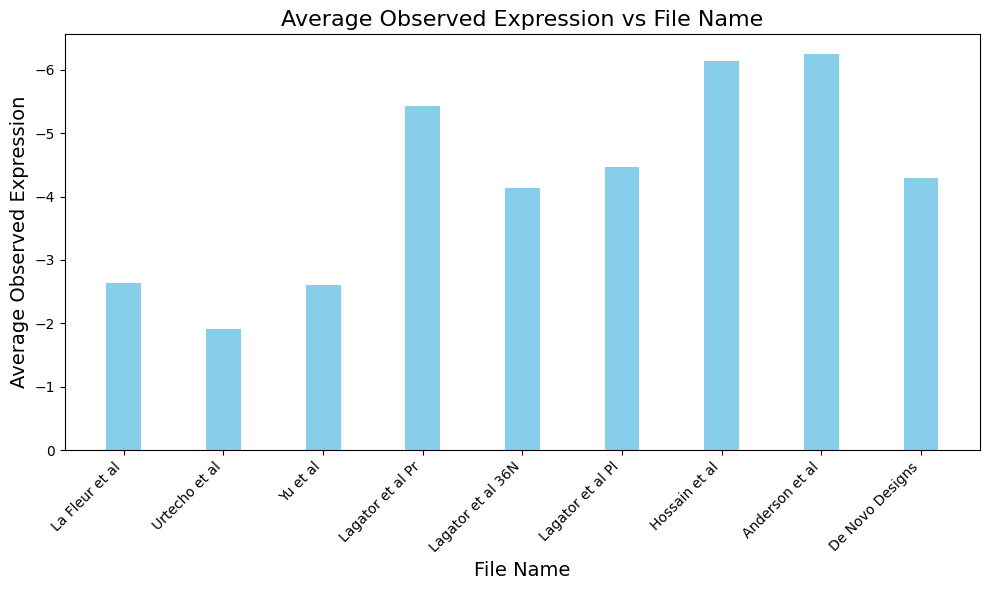

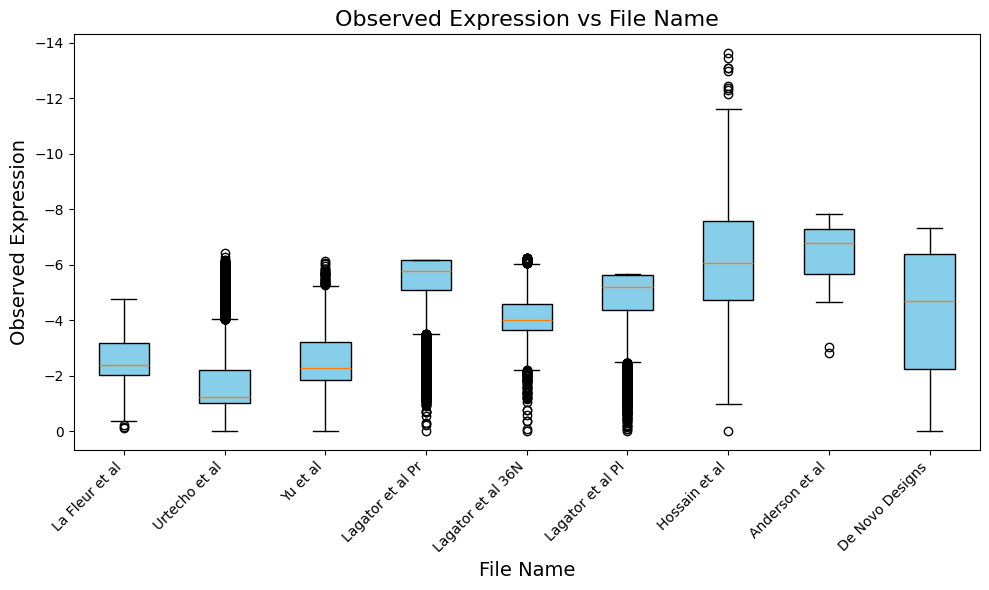

In [9]:
observed_expressions = get_observed_expressions(df)
average_observed_expressions = {file : sum(lengths) / len(lengths) for file, lengths in observed_expressions.items()}

metrics_df['Observed Expression'] = add_to_df(metrics_df, observed_expressions)
metrics_df['Average Observed Expression'] = add_to_df(metrics_df, average_observed_expressions)

plot_barchart(metrics_df, 'Average Observed Expression')
plot_boxplot(metrics_df, 'Observed Expression')

In [10]:
def relative_hamming_distance(seq1, seq2):
    min_length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))
    distance = sum(c1 != c2 for c1, c2 in zip(seq1[:min_length], seq2[:min_length])) + (max_length - min_length)
    return distance / max_length

def hamming_distance(seq1, seq2):
    min_length = min(len(seq1), len(seq2))
    max_length = max(len(seq1), len(seq2))
    return sum(c1 != c2 for c1, c2 in zip(seq1[:min_length], seq2[:min_length])) + (max_length - min_length)

def levenshtein_distance(seq1, seq2):
    '''
    Levenshtein Distance is a string metric for measuring the difference between two sequences.
    Informally, the Levenshtein distance between two words is the minimum number of single-character edits
    (insertions, deletions, or substitutions) required to change one word into the other.
    '''
    len_seq1 = len(seq1) + 1
    len_seq2 = len(seq2) + 1

    dp = [[0 for _ in range(len_seq2)] for _ in range(len_seq1)]

    for i in range(len_seq1):
        dp[i][0] = i
    for j in range(len_seq2):
        dp[0][j] = j

    for i in range(1, len_seq1):
        for j in range(1, len_seq2):
            cost = 0 if seq1[i - 1] == seq2[j - 1] else 1

            dp[i][j] = min(
                dp[i - 1][j] + 1,
                dp[i][j - 1] + 1,
                dp[i - 1][j - 1] + cost
            )

    return dp[-1][-1]

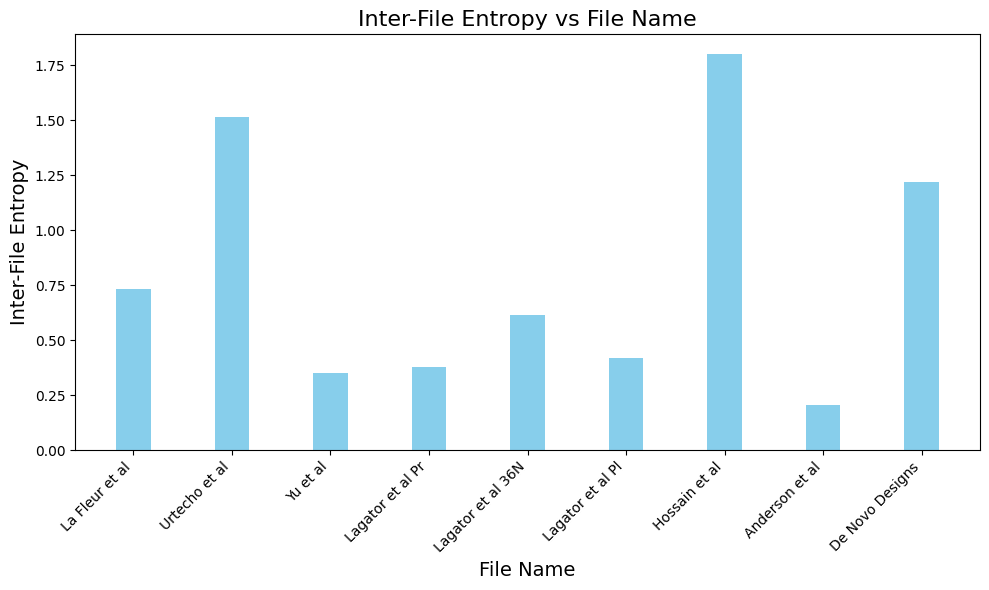

In [11]:
inter_file_entropy = get_inter_file_entropy(df, normalize=True)
metrics_df['Inter-File Entropy'] = add_to_df(metrics_df, inter_file_entropy)

plot_barchart(metrics_df, 'Inter-File Entropy')

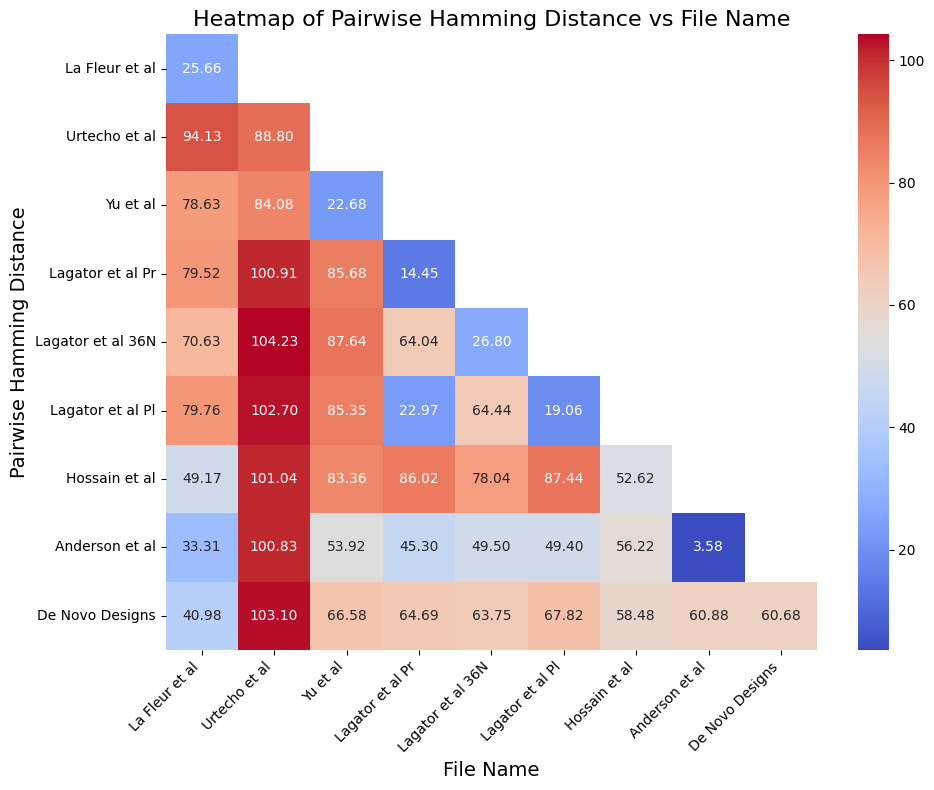

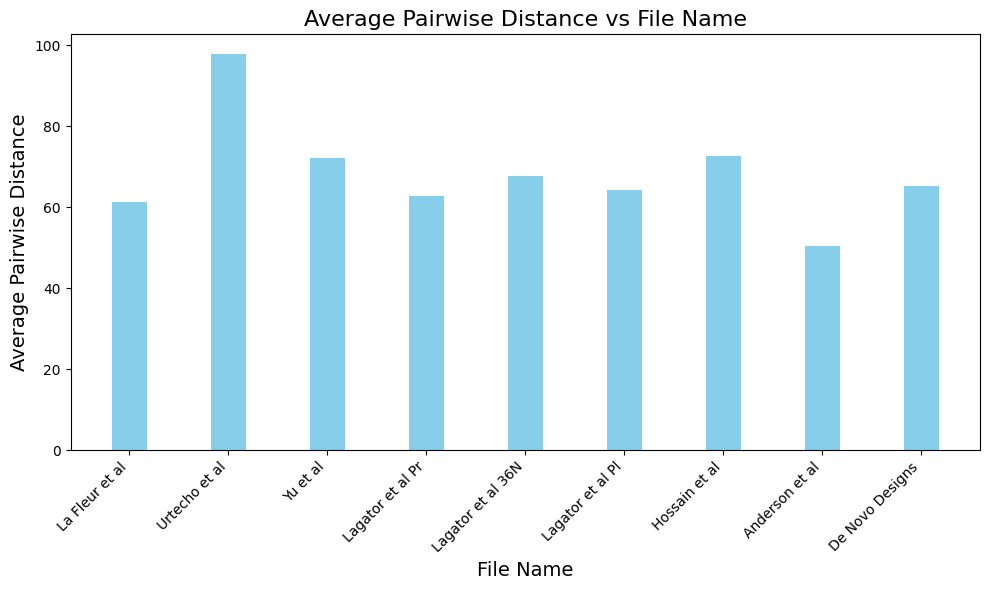

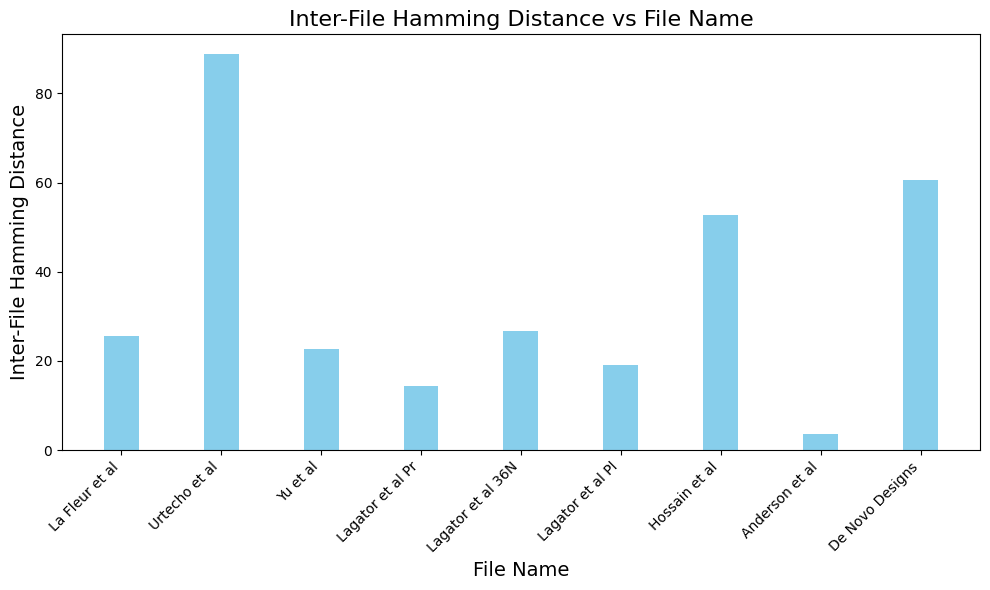

In [12]:
pairwise_file_distance_df = get_pairwise_file_distance(df, order=file_order, n=100, function=hamming_distance)
plot_heatmap(pairwise_file_distance_df, 'Pairwise Hamming Distance', staircase=True, flip_y=False)

average_pairwise_distances = {file : sum(distances) / len(distances) for file, distances in pairwise_file_distance_df.items()}
metrics_df['Average Pairwise Distance'] = add_to_df(metrics_df, average_pairwise_distances)
plot_barchart(metrics_df, 'Average Pairwise Distance')

inter_file_hamming_distance = {
    file1 : data[file1]
    for file1, data in pairwise_file_distance_df.items()
    for file2 in pairwise_file_distance_df.keys()
    if file1 == file2
}
metrics_df['Inter-File Hamming Distance'] = add_to_df(metrics_df, inter_file_hamming_distance)
plot_barchart(metrics_df, 'Inter-File Hamming Distance')

In [13]:
# save metrics_df to CSV
metrics_df.to_csv('Data/CNN_file_metrics.csv', index=False)

# save pairwise_file_distance_df to CSV
pairwise_file_distance_df.to_csv('Data/pairwise_file_distance.csv', index=True)

In [14]:
metrics = [
    'Sequence Count',
    'Average Sequence Length',
    'Average Observed Expression',
    'Inter-File Entropy',
    'Average Pairwise Distance',
    'Inter-File Hamming Distance'
]

metrics_df.head()

,File Name,Training Data CV,All Data CV,Training Data MSE Averages,All Data MSE Averages,Sequence Count,Average Sequence Length,Sequence Lengths,Observed Expression,Average Observed Expression,Inter-File Entropy,Average Pairwise Distance,Inter-File Hamming Distance
0,La Fleur et al,0.072744,0.227085,0.000894,0.095725,5391,73.86496,"[74, 74, 74, 74, 74, 73, 73, 73, 73, 73, 74, 7...","[-3.386326274, -3.392439032, -3.698902914, -3....",-2.638173,0.732649,61.310662,25.660302
1,Urtecho et al,0.164779,0.172279,0.000367,0.033381,10898,150.00000,"[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[-1.046079556, -1.431813084, -1.098599732, -1....",-1.903470,1.513936,97.757292,88.797035
2,Yu et al,0.258020,0.167959,0.001616,0.332792,1493,150.00000,"[150, 150, 150, 150, 150, 150, 150, 150, 150, ...","[-2.416324554, -1.69328491, -1.428471584, -4.2...",-2.598650,0.352242,71.990849,22.676231
3,Lagator et al Pr,0.039902,0.196077,0.001881,0.072140,12194,139.00000,"[139, 139, 139, 139, 139, 139, 139, 139, 139, ...","[-6.133261487, -6.08031203, -5.798335905, -5.1...",-5.421390,0.375852,62.621899,14.449095
4,Lagator et al 36N,0.026652,0.108187,0.002698,0.117030,11485,116.00000,"[116, 116, 116, 116, 116, 116, 116, 116, 116, ...","[-6.023111372, -6.067880909, -3.65581588, -6.2...",-4.131152,0.614703,67.674297,26.800603


### Correlation analysis: plot a scatter plot between each metric and Training Data CV, All Data CV, Training Data Averages, and All Data Averages

---

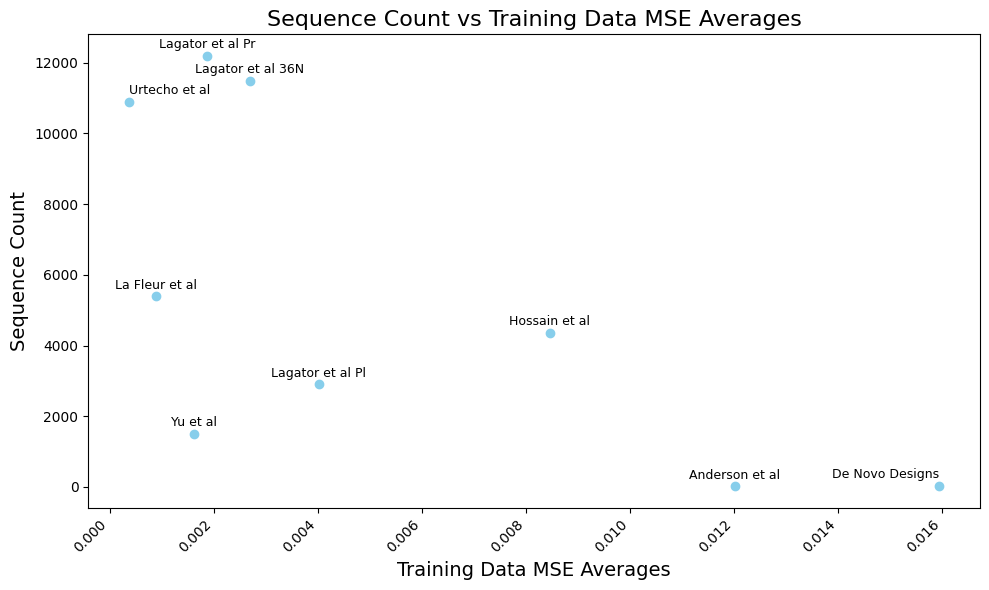

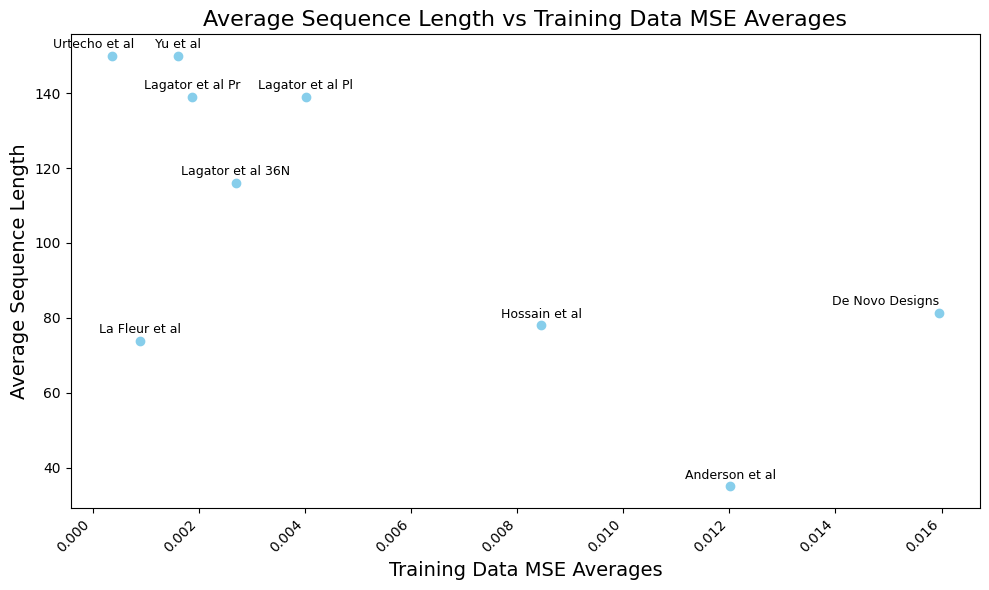

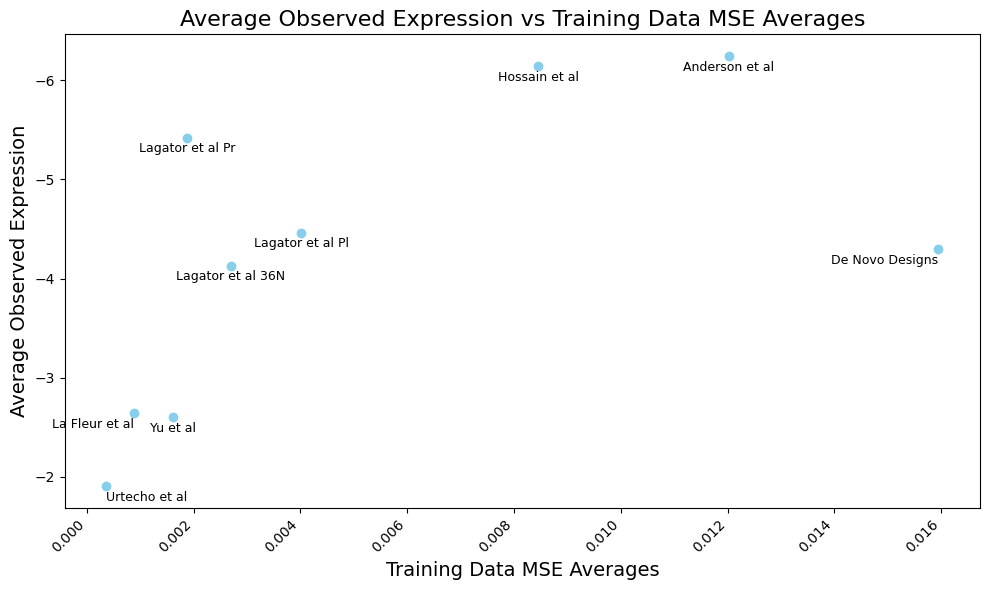

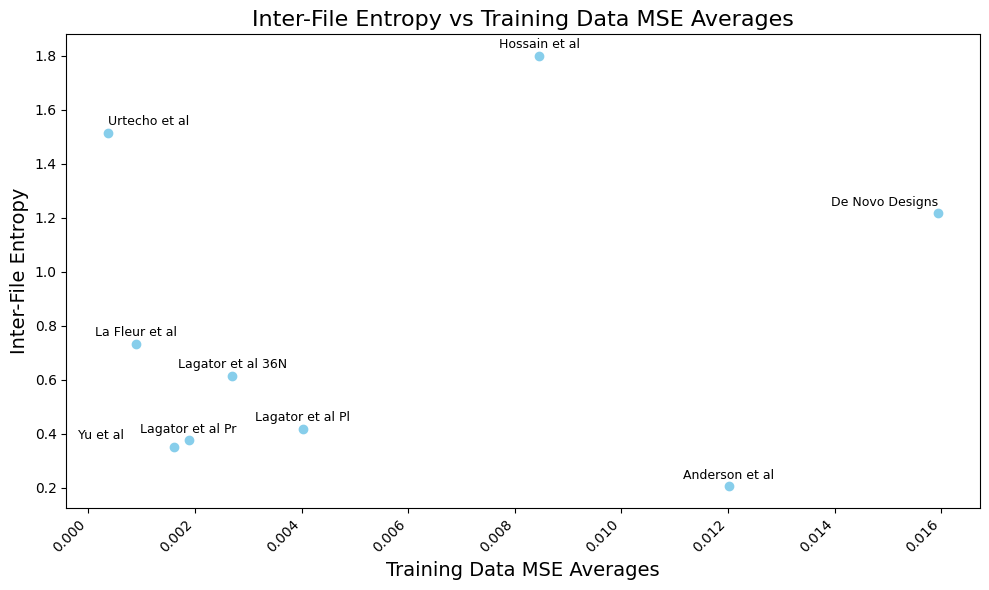

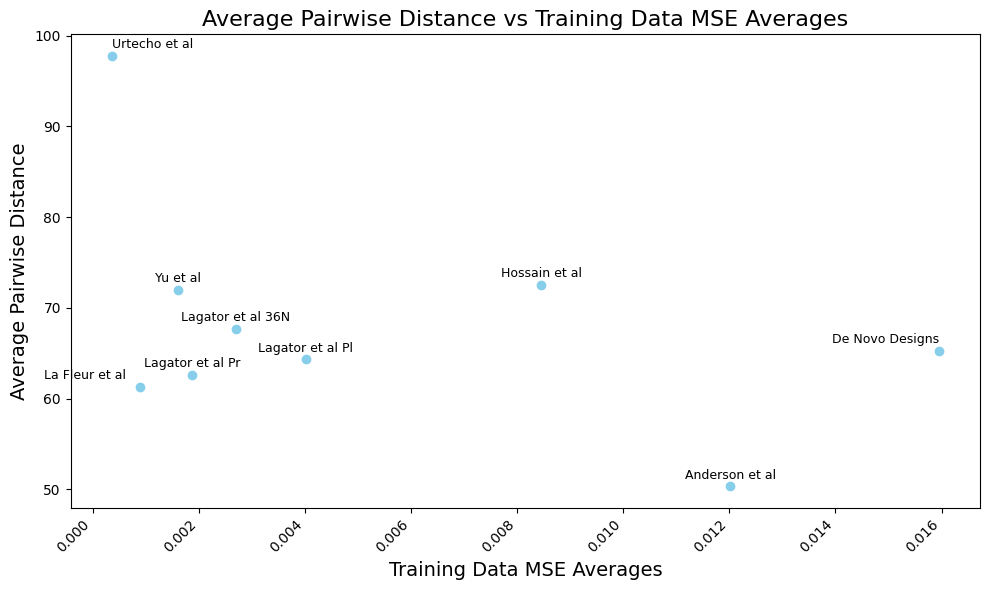

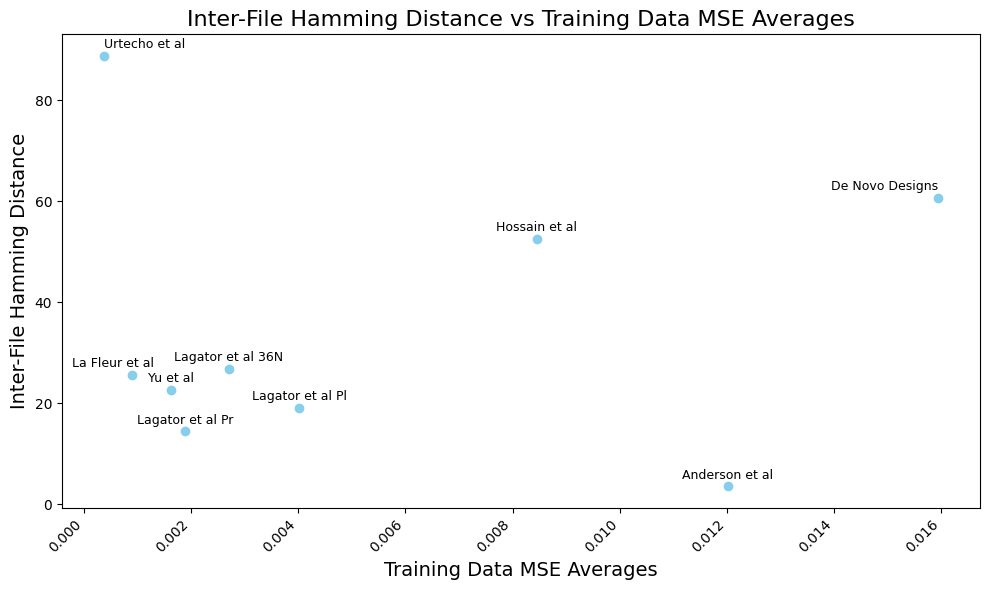

In [15]:
# Test the correlation between the metrics and Training Data Averages

for metric in metrics:
    plot_scatterplot(metrics_df, metric, 'Training Data MSE Averages', 'File Name')

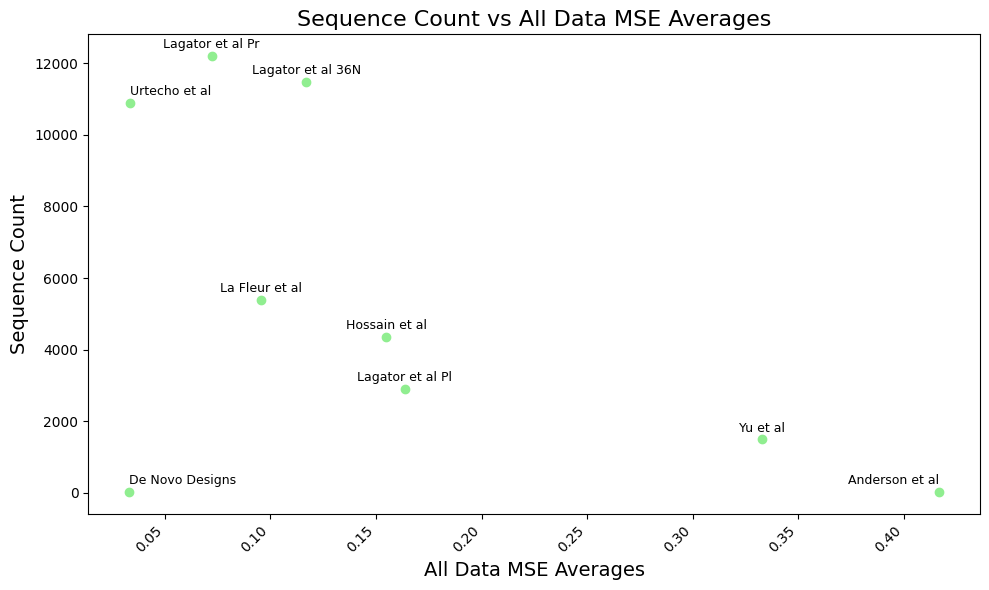

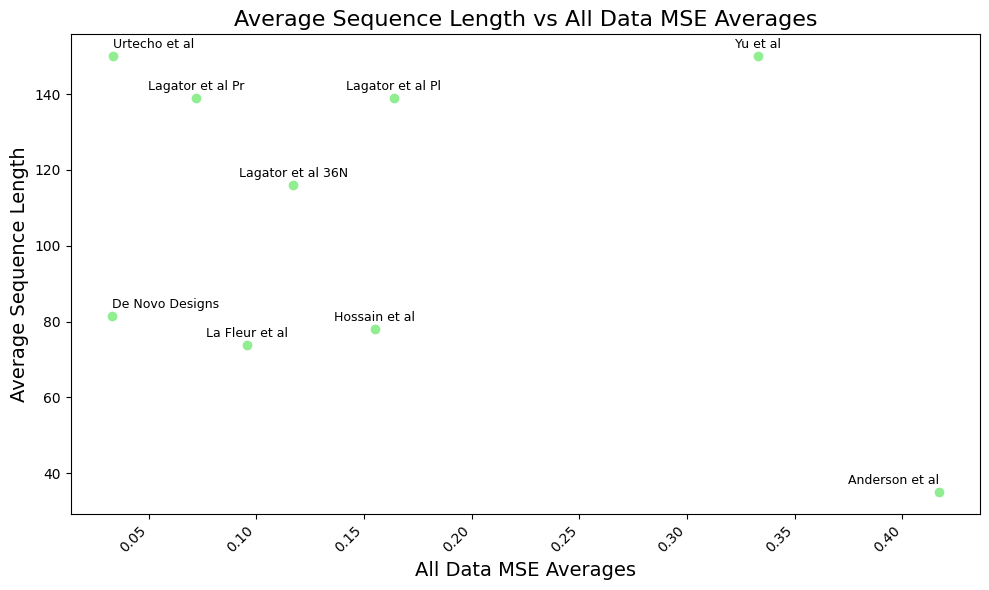

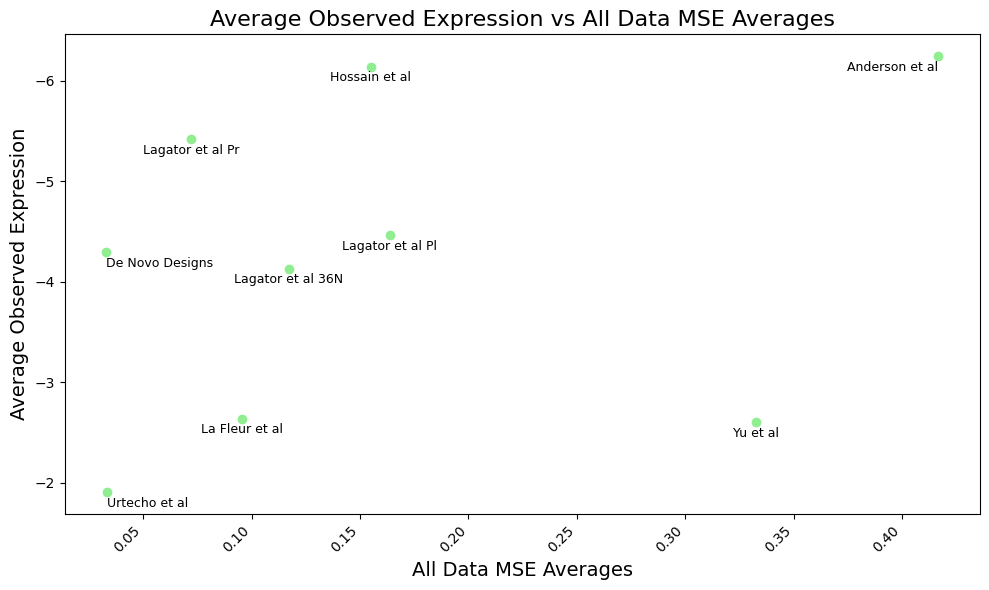

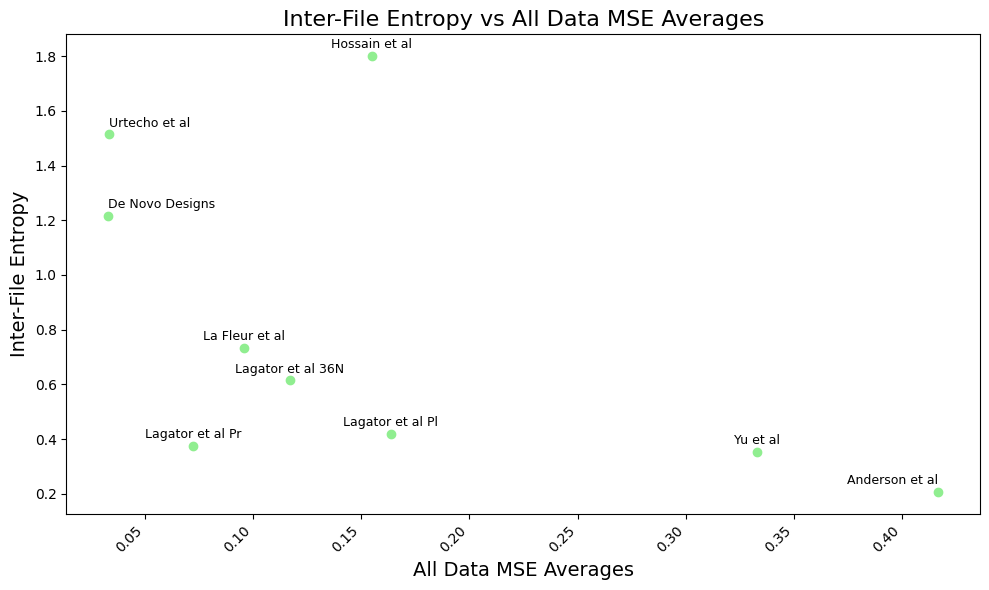

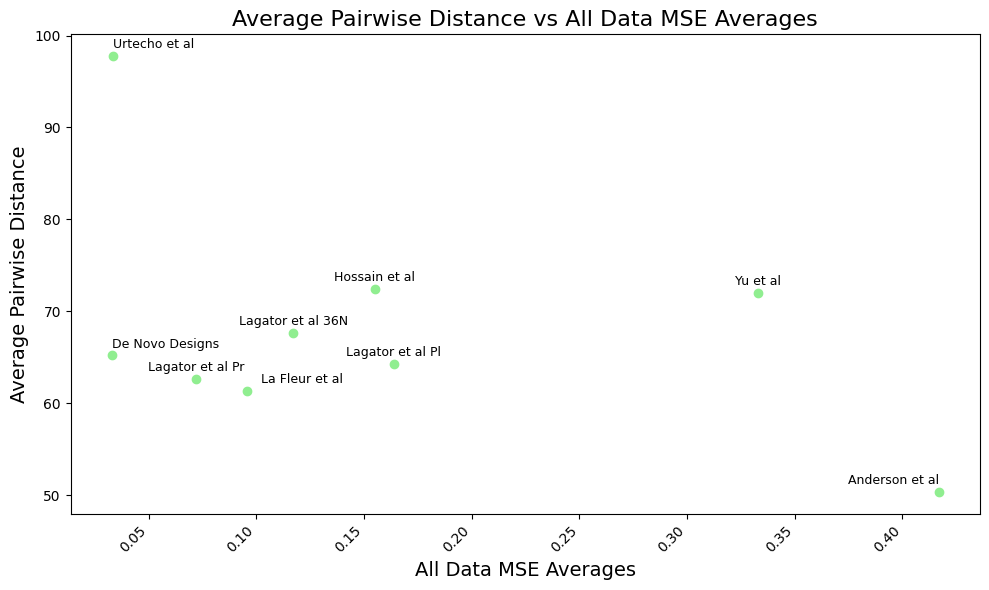

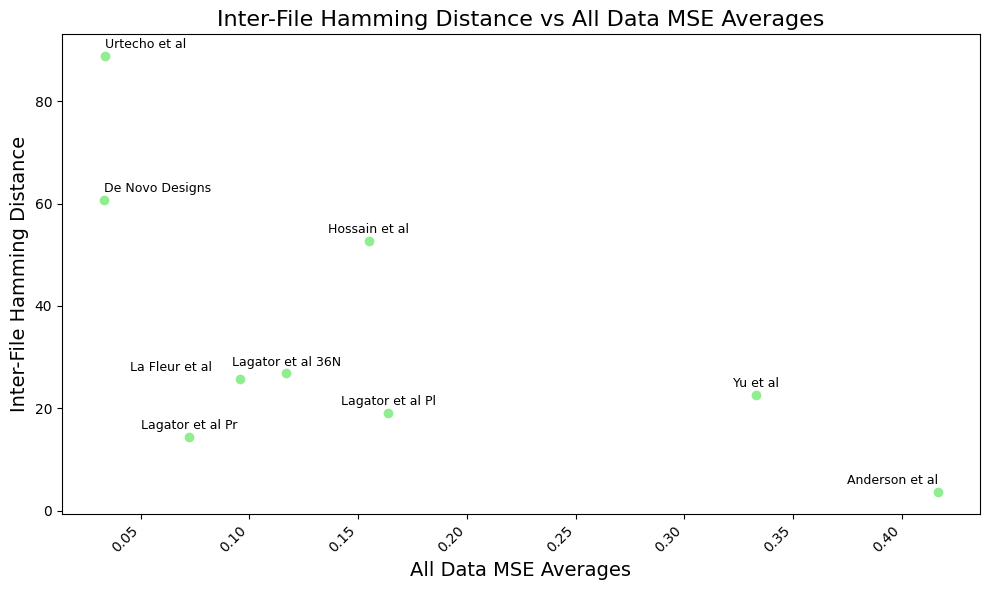

In [16]:
# Test the correlation between the metrics and All Data Averages

for metric in metrics:
    plot_scatterplot(metrics_df, metric, 'All Data MSE Averages', 'File Name')

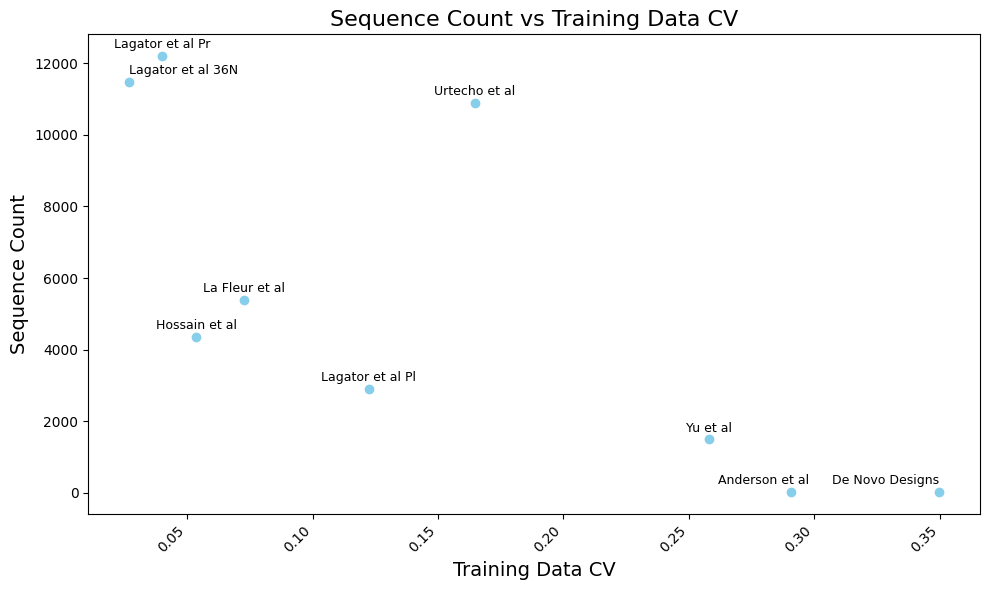

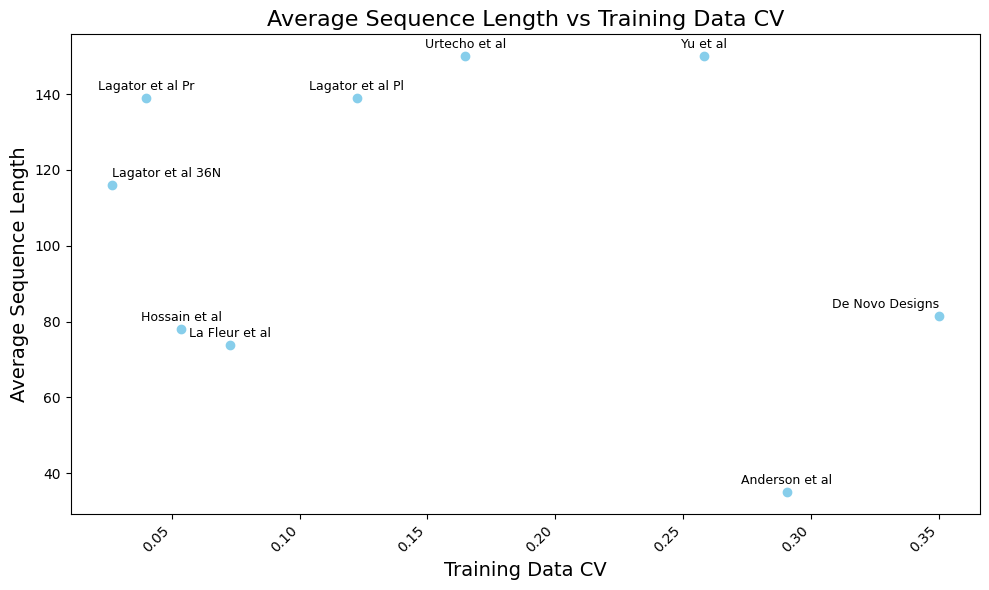

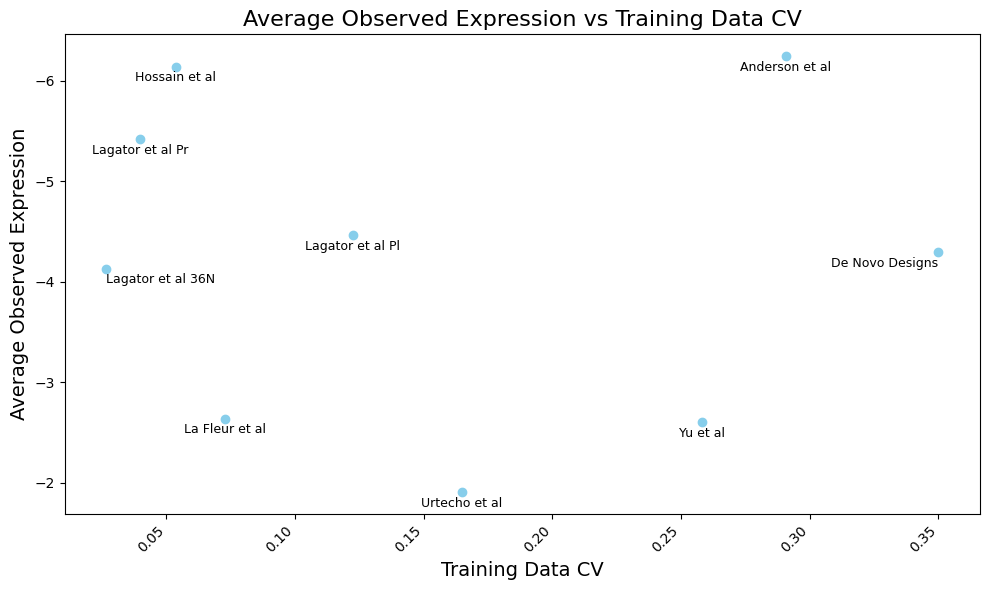

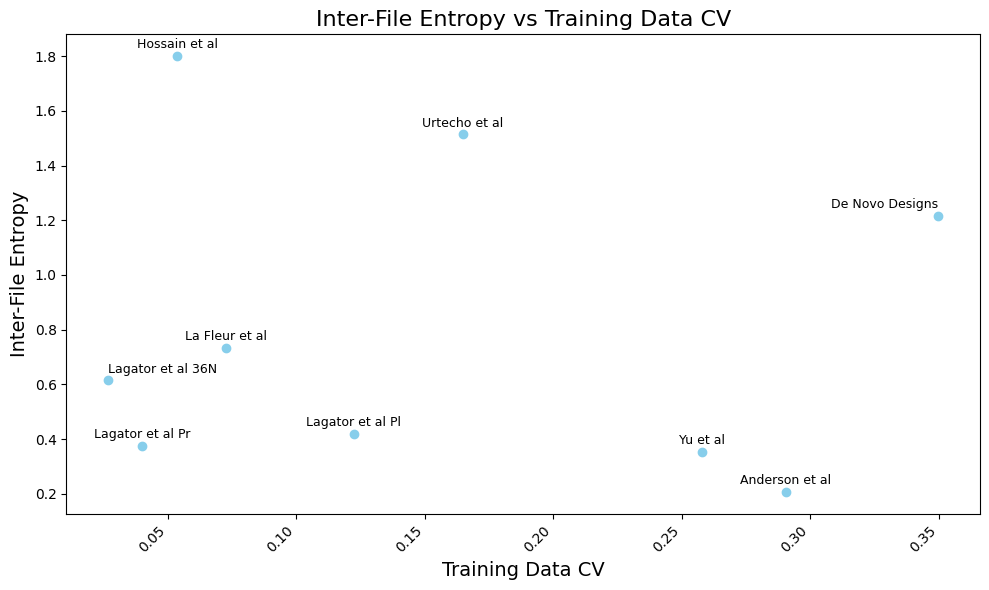

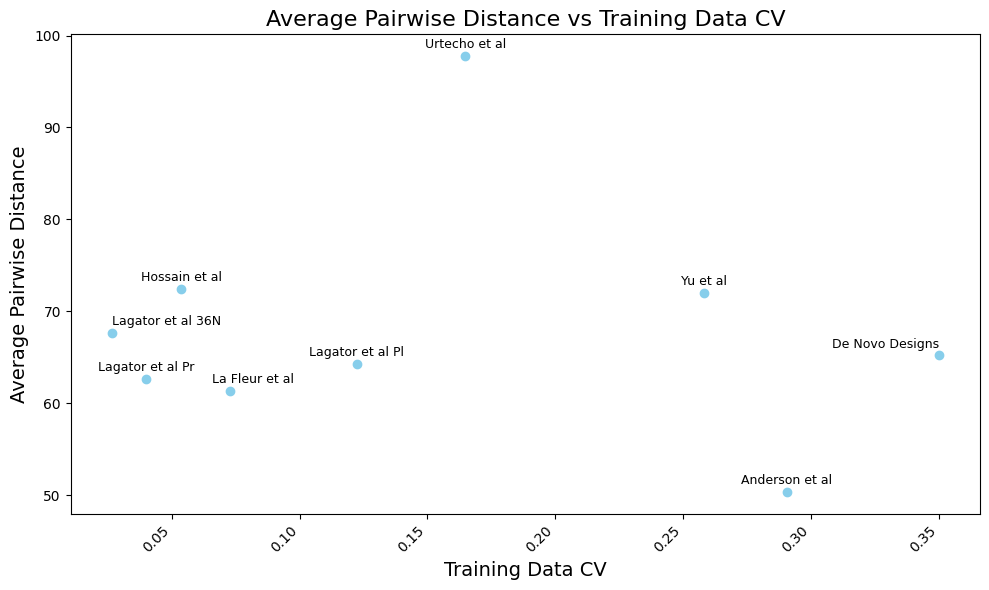

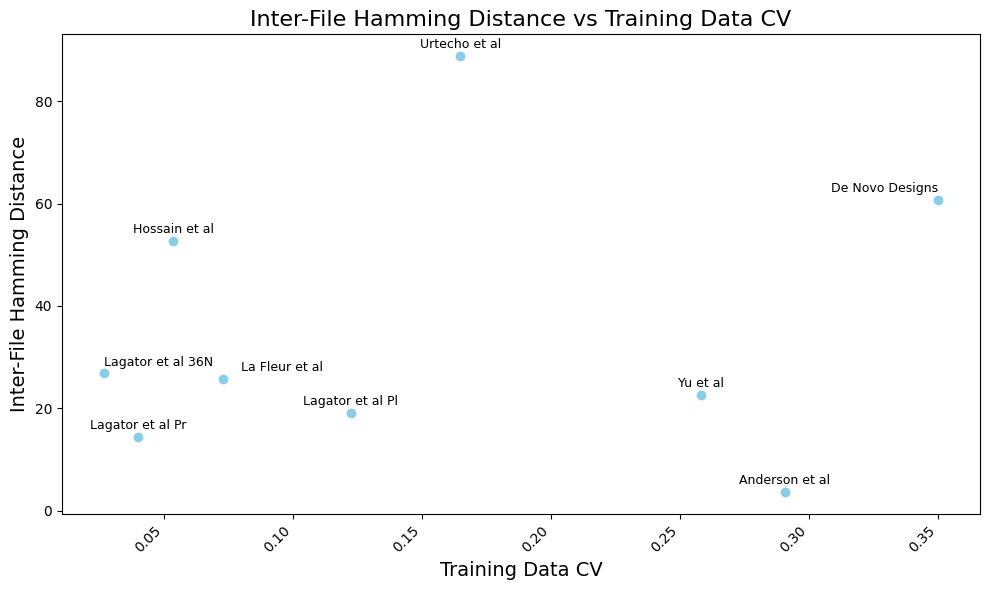

In [17]:
# Test the correlation between the metrics and Training Data CV

for metric in metrics:
    plot_scatterplot(metrics_df, metric, 'Training Data CV', 'File Name')

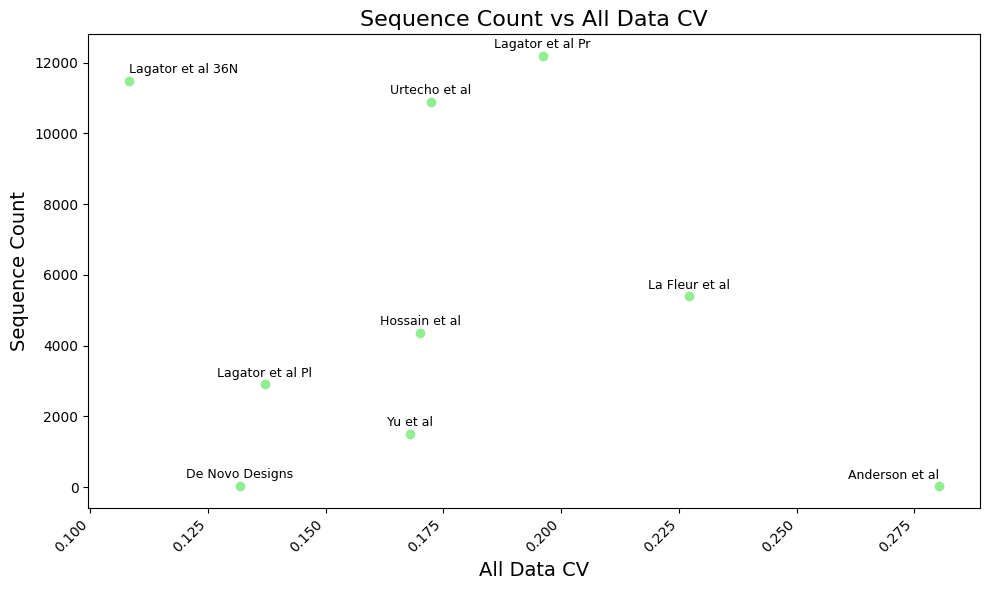

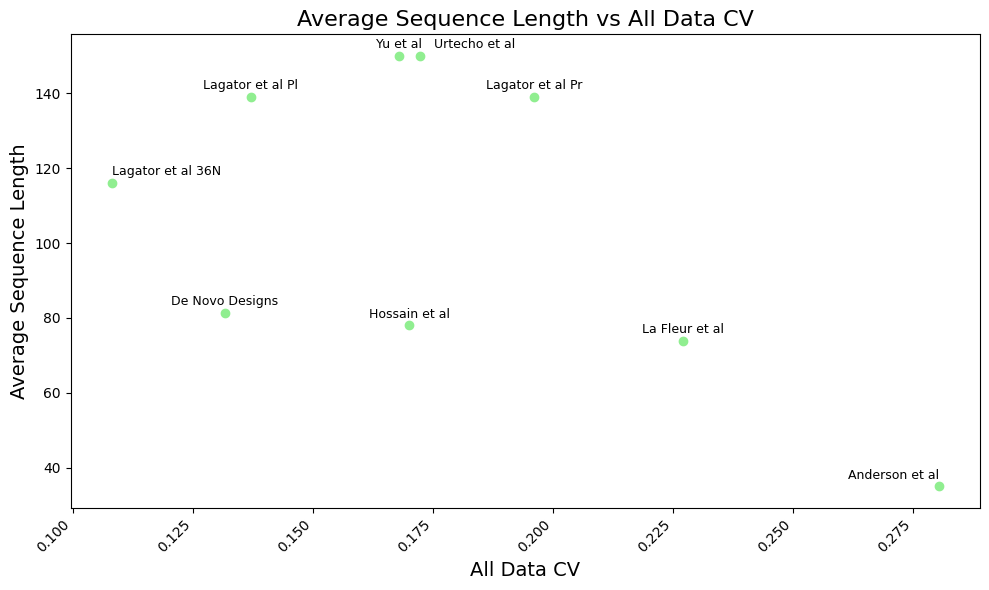

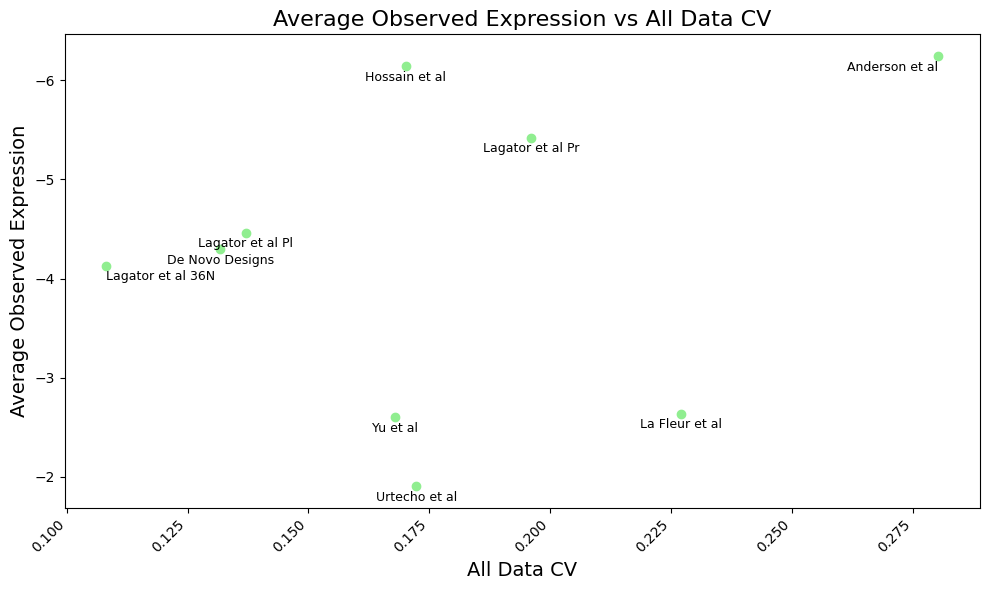

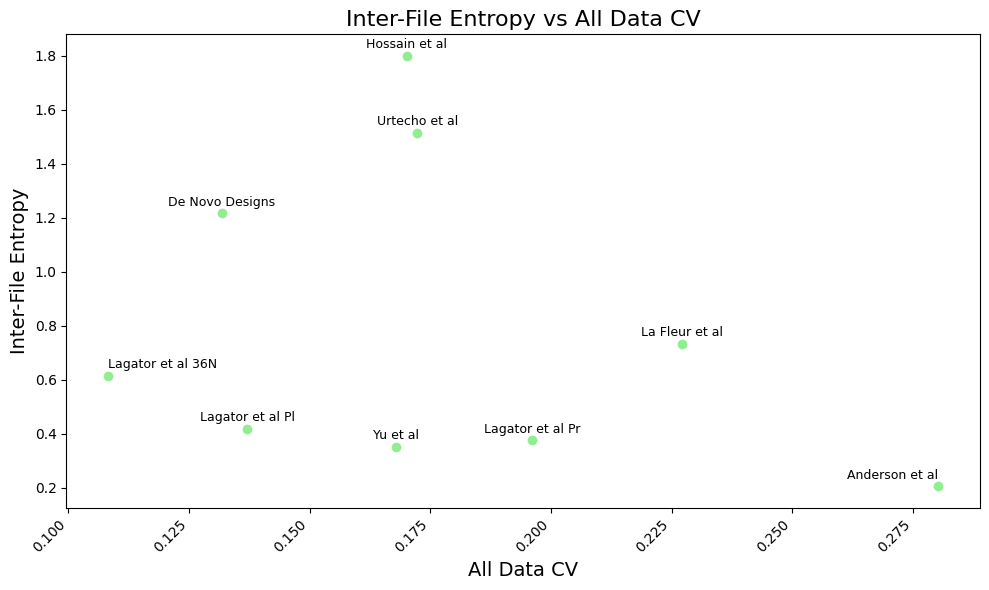

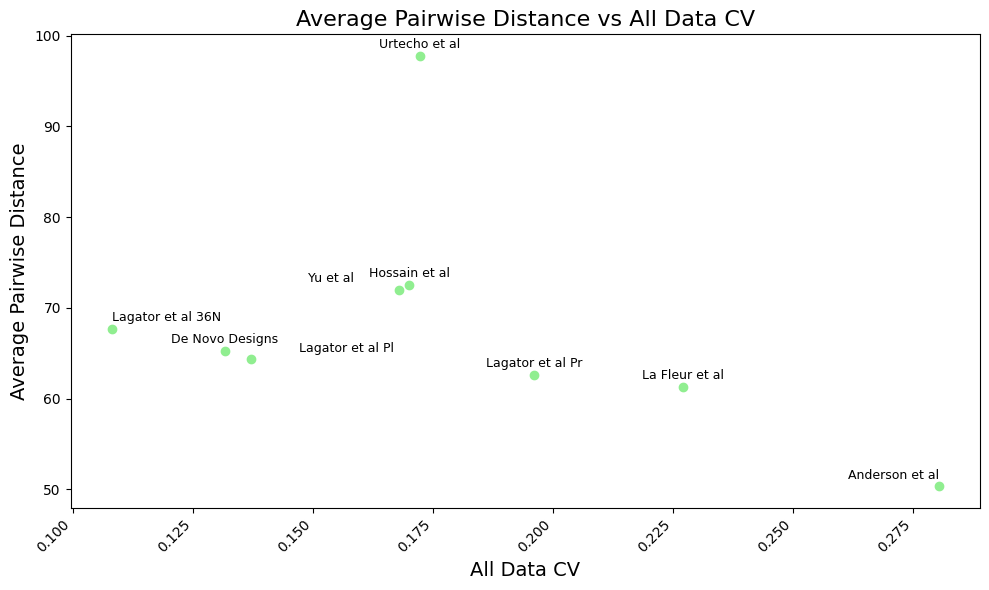

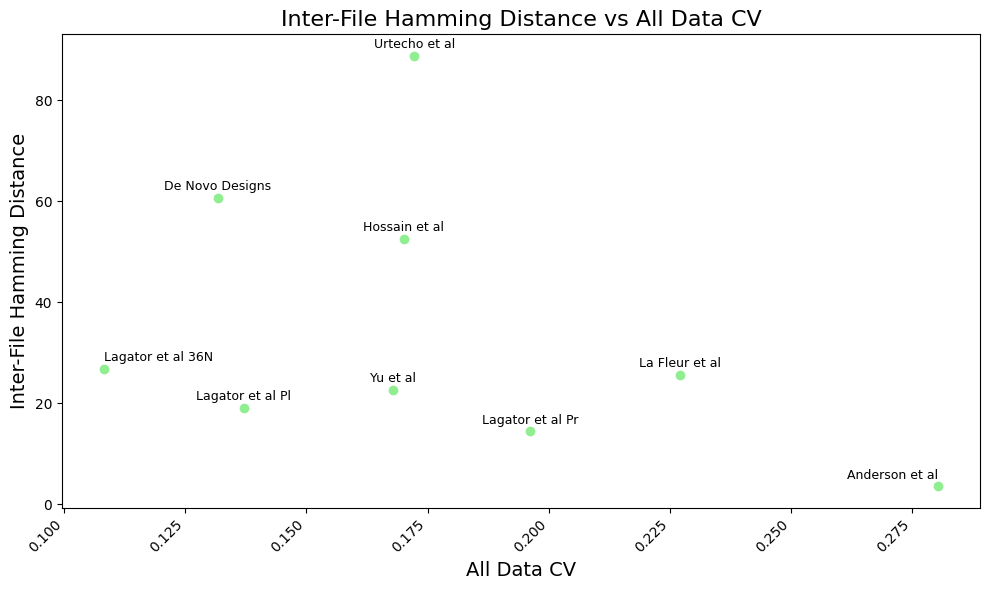

In [18]:
# Test the correlation between the metrics and All Data CV

for metric in metrics:
    plot_scatterplot(metrics_df, metric, 'All Data CV', 'File Name')

### Other plots

---

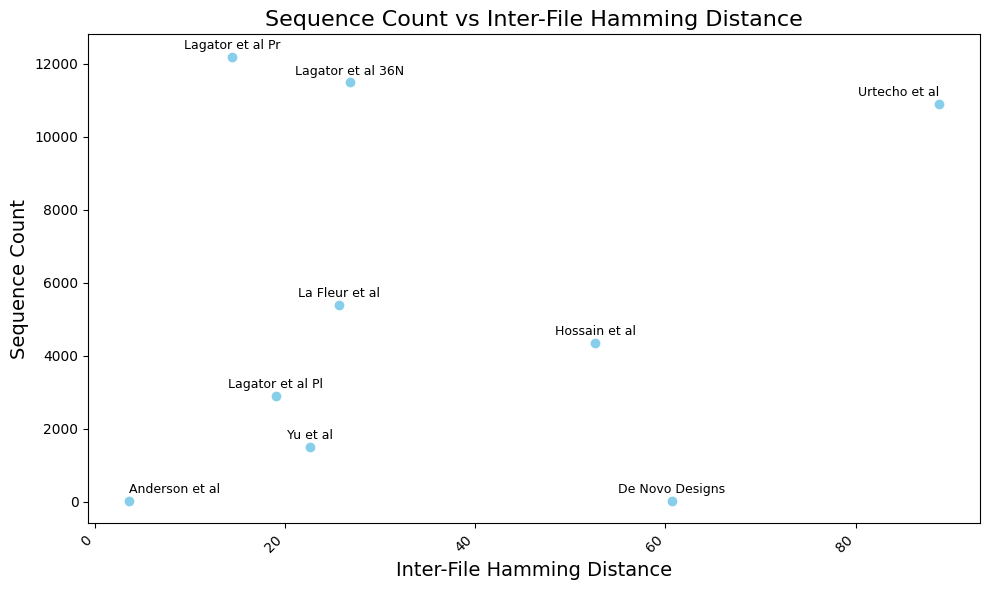

In [19]:
plot_scatterplot(metrics_df, 'Sequence Count', 'Inter-File Hamming Distance', 'File Name')

In [20]:
# data = {
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }
# colors = {
#     'Inter-File Hamming Distance' : 'skyblue',
#     'Pairwise Distance' : 'lightgreen',
# }
# multiple_bar_chart(data, file_order, y_label='Normalized Variance', title='Average Variance Between and Within Files', colors=colors)

# data = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }
# multiple_bar_chart(data, file_order, y_label='', title='')


In [21]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# plot_metric_mse(metrics, file_order, all_results)

In [22]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# plot_relative_data(metrics, file_order, all_results, training_data=False)

In [23]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# plot_relative_data(metrics, file_order, all_results, all_data=False)

In [24]:
# metrics = {
#     'Dataset Size' : file_sequence_counts,
#     'Sequence Lengths' : average_sequence_lengths,
#     'Observed Expressions' : average_observed_expressions,
#     'Inter-File Hamming Distance' : inter_file_hamming_distance,
#     'Pairwise Distance' : average_pairwise_distances,
# }

# plot_relative_data(metrics, file_order, all_results)

In [25]:
# relative_variance = {}
# for file in file_order:
#     relative_variance[file] = average_pairwise_distances[file] / inter_file_hamming_distance[file]

# file_bar_chart(relative_variance, file_order, y_label='Relative Variance', title='Pairwise Variance / Inter-Variance')

# relative_variance = {}
# for file in file_order:
#     relative_variance[file] = average_sequence_lengths[file] / inter_file_hamming_distance[file]

# file_bar_chart(relative_variance, file_order, y_label='Relative Variance', title='Dataset Size / Inter-Variance')